In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL

from caption_util import create_caption_from_aug_img_tensor, create_caption_from_img_file, plot_caption_pred
from config import Config
from datetime import datetime
from img_embedding import ImageEmbedding
from img_transformer import ImgTransformer
from img_util import show_img_tensor_CHW, inverse_img_aug, load_img_tensor
from fliker_comment_tokenizer import FlikerCommentTokenizer
from img_comment_dataset import ImgCommentDataset
from model_util import count_parameters, load_model
from pathlib import Path
from text_casual_mask_transformer import TextMaskedTransformer
from text_token_embedding import TextTokenEmbedding
from text_util import normalize_comment
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from vlm_img_lang_model import ImgLanguageModel
from vlm_train import train_model

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.profiler import profile, record_function, ProfilerActivity
from torch.utils.data import DataLoader
import torchvision.transforms.functional as VF

from common_util import get_logger

logger = get_logger(__name__)

plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
# train_model(debug=True)

# Load Datasets
-----

In [2]:
config = Config()

train_dataset = ImgCommentDataset(config, split="train")
eval_dataset = ImgCommentDataset(config, split="eval")
test_dataset = ImgCommentDataset(config, split="test")
logger.info(f"train_dataset:  {len(train_dataset)}")
logger.info(f"eval_dataset:  {len(eval_dataset)}")
logger.info(f"test_dataset:  {len(test_dataset)}")


# Data Loader
BATCH_SIZE = 20
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
logger.info(f"train_dataloader:  {len(train_dataloader)}")
logger.info(f"eval_data_loader:  {len(eval_dataloader)}")
logger.info(f"test_data_loader:  {len(test_dataloader)}")

2024-12-07 09:02:19,224 - img_comment_dataset - INFO - Loaded 158915 fliker image-caption data items.
2024-12-07 09:02:20,237 - img_comment_dataset - INFO - Loaded 591753 coco image-caption data items.
2024-12-07 09:02:24,272 - img_comment_dataset - INFO - Loaded 768536 visual-genome image-caption data items.
2024-12-07 09:02:29,209 - img_comment_dataset - INFO - Loaded 158915 fliker image-caption data items.
2024-12-07 09:02:30,279 - img_comment_dataset - INFO - Loaded 591753 coco image-caption data items.
2024-12-07 09:02:34,485 - img_comment_dataset - INFO - Loaded 768536 visual-genome image-caption data items.
2024-12-07 09:02:39,520 - img_comment_dataset - INFO - Loaded 158915 fliker image-caption data items.
2024-12-07 09:02:40,750 - img_comment_dataset - INFO - Loaded 591753 coco image-caption data items.
2024-12-07 09:02:44,904 - img_comment_dataset - INFO - Loaded 768536 visual-genome image-caption data items.
2024-12-07 09:02:49,330 - __main__ - INFO - train_dataset:  1093826

In [3]:
(
    batch_aug_img_tensor1,
    batch_aug_img_tensor2,
    batch_img_id_tensor,
    batch_comment_encoding,
    batch_text_mask,
) = next(iter(train_dataloader))
logger.info(f"batch_aug_img_tensor1: {batch_aug_img_tensor1.size()}")
logger.info(f"batch_aug_img_tensor2: {batch_aug_img_tensor2.size()}")
logger.info(f"batch_img_id_tensor: {batch_img_id_tensor.size()}")
logger.info(f"batch_comment_encoding: {batch_comment_encoding.size()}")
logger.info(f"batch_text_mask: {batch_text_mask.size()}")

2024-12-07 09:03:21,653 - fliker_comment_tokenizer - INFO - tokens: 10000
2024-12-07 09:03:21,653 - fliker_comment_tokenizer - INFO - tokenizer.is_fast: True
2024-12-07 09:03:21,827 - __main__ - INFO - batch_aug_img_tensor1: torch.Size([20, 3, 224, 224])
2024-12-07 09:03:21,827 - __main__ - INFO - batch_aug_img_tensor2: torch.Size([20, 3, 224, 224])
2024-12-07 09:03:21,828 - __main__ - INFO - batch_img_id_tensor: torch.Size([20])
2024-12-07 09:03:21,828 - __main__ - INFO - batch_comment_encoding: torch.Size([20, 50])
2024-12-07 09:03:21,828 - __main__ - INFO - batch_text_mask: torch.Size([20, 50])


# Load Model
----

In [5]:
device = torch.device("mps")

model_file = "/Users/chengbai/ml/cheng_git/notebooks/vlm_caption_model_20241205_212305_6_75500.pt"  # "/Users/chengbai/ml/cheng_git/notebooks/vlm_caption_model_20241123_110346_final.pt"  # "/Users/chengbai/ml/cheng_git/notebooks/vlm_caption_model_2_20241004_030026_234476.pt"
target_model = load_model(config=config, model_file=model_file, device=device)
target_model = target_model.eval()

2024-12-07 09:03:44,138 - fliker_comment_tokenizer - INFO - tokens: 10000
2024-12-07 09:03:44,138 - fliker_comment_tokenizer - INFO - tokenizer.is_fast: True
2024-12-07 09:03:44,497 - fliker_comment_tokenizer - INFO - tokens: 10000
2024-12-07 09:03:44,497 - fliker_comment_tokenizer - INFO - tokenizer.is_fast: True
dict_keys(['epoch', 'global_step', 'total_steps', 'model_state_dict', 'optimizer_state_dict', 'loss', 'config', 'train_settings'])


# Eval Model Perf
----

In [5]:
def evaluate_model_perf(target_model: nn.Module, split: str):
    config = Config

    target_model.eval()

    # Create Dataset and DataLoader
    BATCH_SIZE = 20
    target_dataset = ImgCommentDataset(config, split=split)
    target_dataloader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=False)
    logger.info(f"split:  {split}")
    logger.info(f"target_dataset:  {len(target_dataset)}")
    logger.info(f"target_dataloader:  {len(target_dataloader)}")

    img_img_losses = []
    img_text_losses = []
    text_img_losses = []
    lm_losses = []
    img_img_preds = []
    img_text_preds = []
    text_img_preds = []
    img_img_accuracies = []
    img_text_accuracies = []
    text_img_accuracies = []
    with torch.no_grad():
        for idx, data in tqdm(
            enumerate(target_dataloader), total=len(target_dataloader)
        ):
            (
                batch_aug_img_tensor1,
                batch_aug_img_tensor2,
                batch_img_id_tensor,
                batch_text_tensor,
                batch_text_mask_tensor,
            ) = data
            batch_aug_img_tensor1 = batch_aug_img_tensor1.to(device)
            batch_aug_img_tensor2 = batch_aug_img_tensor2.to(device)
            batch_img_id_tensor = batch_img_id_tensor.to(device)
            batch_text_tensor = batch_text_tensor.to(device)
            batch_text_mask_tensor = batch_text_mask_tensor.to(device)
            (
                img_img_loss,
                img_text_loss,
                text_img_loss,
                img_img_contrastive_prob,
                img_text_contrastive_prob,
                text_img_contrastive_prob,
                lm_loss,
                lm_logit,
            ) = target_model(
                batch_aug_img_tensor1=batch_aug_img_tensor1,
                batch_aug_img_tensor2=batch_aug_img_tensor2,
                batch_text_tensor=batch_text_tensor,
                batch_text_mask_tensor=batch_text_mask_tensor,
                batch_img_id_tensor=batch_img_id_tensor,
            )

            img_img_losses.append(img_img_loss.cpu())
            img_text_losses.append(img_text_loss.cpu())
            text_img_losses.append(text_img_loss.cpu())
            lm_losses.append(lm_loss.cpu())

            img_img_pred = torch.argmax(img_img_contrastive_prob, dim=1).cpu()
            img_img_preds.extend(img_img_pred)

            img_text_pred = torch.argmax(img_text_contrastive_prob, dim=1).cpu()
            img_text_preds.extend(img_text_pred)

            text_img_pred = torch.argmax(text_img_contrastive_prob, dim=1).cpu()
            text_img_preds.extend(text_img_pred)

            label_mask = torch.arange(img_img_pred.size()[0]).cpu()
            img_img_accuracy = img_img_pred == label_mask
            img_img_accuracies.extend(img_img_accuracy)

            img_text_accuracy = img_text_pred == label_mask
            img_text_accuracies.extend(img_text_accuracy)

            text_img_accuracy = text_img_pred == label_mask
            text_img_accuracies.extend(text_img_accuracy)

            # if idx > 5:
            #     break

    img_img_losses = torch.tensor(img_img_losses)
    img_text_losses = torch.tensor(img_text_losses)
    text_img_losses = torch.tensor(text_img_losses)
    lm_losses = torch.tensor(lm_losses)
    return (
        img_img_losses,
        img_text_losses,
        text_img_losses,
        lm_losses,
        img_img_preds,
        img_text_preds,
        text_img_preds,
        img_img_accuracies,
        img_text_accuracies,
        text_img_accuracies,
    )


def viz_loss(
    title: str, img_img_losses, img_text_losses, text_img_losses, lm_losses, bins=100
):
    # fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
    df = pd.DataFrame(
        {
            "img_img_losses": np.array(img_img_losses),
            "img_text_losses": np.array(img_text_losses),
            "text_img_losses": np.array(text_img_losses),
            "lm_losses": np.array(lm_losses),
        }
    )
    df.hist(bins=bins)
    # set title and axis labels
    plt.suptitle(title, x=0.5, y=1.05, ha="center", fontsize="small")
    # fig.text(0.5, 0.04, 'common X', ha='center')
    # fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')


def viz_predictions(
    title: str, img_img_preds, img_text_preds, text_img_preds, bins=BATCH_SIZE
):
    # fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
    df = pd.DataFrame(
        {
            "img_img_preds": np.array(img_img_preds),
            "img_text_preds": np.array(img_text_preds),
            "text_img_preds": np.array(text_img_preds),
        }
    )
    df.hist(bins=bins)
    # set title and axis labels
    plt.suptitle(title, x=0.5, y=1.05, ha="center", fontsize="small")
    # fig.text(0.5, 0.04, 'common X', ha='center')
    # fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')

2024-12-06 10:47:53,251 - img_comment_dataset - INFO - Loaded 158915 fliker image-caption data items.
2024-12-06 10:47:54,354 - img_comment_dataset - INFO - Loaded 591753 coco image-caption data items.
2024-12-06 10:47:58,588 - img_comment_dataset - INFO - Loaded 768536 visual-genome image-caption data items.
2024-12-06 10:48:02,922 - __main__ - INFO - split:  test
2024-12-06 10:48:02,923 - __main__ - INFO - target_dataset:  151921
2024-12-06 10:48:02,923 - __main__ - INFO - target_dataloader:  7597


  0%|          | 0/7597 [00:00<?, ?it/s]

2024-12-06 10:48:02,967 - fliker_comment_tokenizer - INFO - tokens: 10000
2024-12-06 10:48:02,968 - fliker_comment_tokenizer - INFO - tokenizer.is_fast: True


100%|██████████| 7597/7597 [44:25<00:00,  2.85it/s]

2024-12-06 11:32:28,897 - __main__ - INFO - img_img_losses: mean-2.6008708477020264, std-0.557098925113678
2024-12-06 11:32:28,897 - __main__ - INFO - img_text_losses: mean-3.3644859790802, std-0.7034115195274353
2024-12-06 11:32:28,898 - __main__ - INFO - text_img_losses: mean-2.4667038917541504, std-0.41098710894584656
2024-12-06 11:32:28,898 - __main__ - INFO - lm_losses: mean-0.0015439190901815891, std-0.012441026978194714


2024-12-06 11:32:29,059 - __main__ - INFO - img-img accuracy: 0.1706676483154297
2024-12-06 11:32:29,213 - __main__ - INFO - img-text accuracy: 0.15383653342723846
2024-12-06 11:32:29,373 - __main__ - INFO - text-img accuracy: 0.14867596328258514


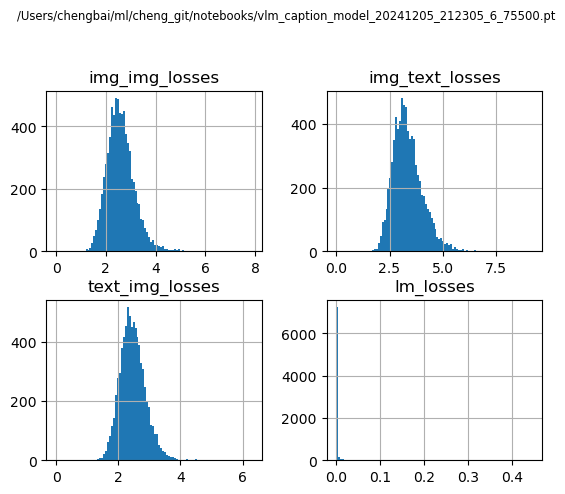

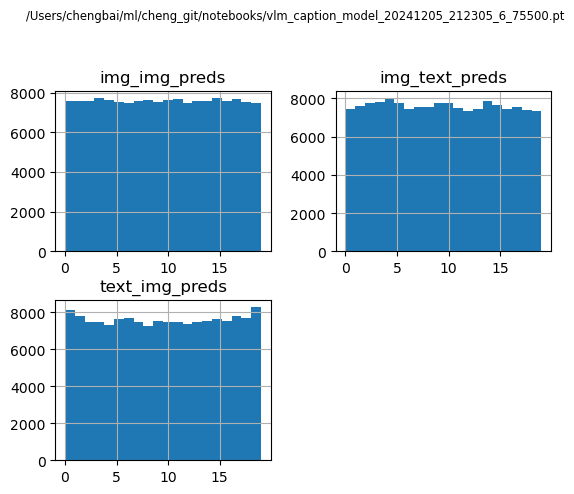

In [7]:
(
    img_img_losses,
    img_text_losses,
    text_img_losses,
    lm_losses,
    img_img_preds,
    img_text_preds,
    text_img_preds,
    img_img_accuracies,
    img_text_accuracies,
    text_img_accuracies,
) = evaluate_model_perf(target_model=target_model, split="test")
logger.info(f"img_img_losses: mean-{img_img_losses.mean()}, std-{img_img_losses.std()}")
logger.info(
    f"img_text_losses: mean-{img_text_losses.mean()}, std-{img_text_losses.std()}"
)
logger.info(
    f"text_img_losses: mean-{text_img_losses.mean()}, std-{text_img_losses.std()}"
)
logger.info(f"lm_losses: mean-{lm_losses.mean()}, std-{lm_losses.std()}")
logger.info(f"img-img accuracy: {sum(img_img_accuracies)/len(img_img_accuracies)}")
logger.info(f"img-text accuracy: {sum(img_text_accuracies)/len(img_text_accuracies)}")
logger.info(f"text-img accuracy: {sum(text_img_accuracies)/len(text_img_accuracies)}")

viz_loss(model_file, img_img_losses, img_text_losses, text_img_losses, lm_losses)
viz_predictions(model_file, img_img_preds, img_text_preds, text_img_preds)

Loaded 158915 fliker image-caption data items.
Loaded 591753 coco image-caption data items.
split:  test
target_dataset:  75067
target_dataloader:  3754


  0%|          | 0/3754 [00:00<?, ?it/s]

tokens: 10000
tokenizer.is_fast: True


100%|██████████| 3754/3754 [35:35<00:00,  1.76it/s]


img_img_losses: mean-0.20809760689735413, std-0.19798429310321808
img_text_losses: mean-1.8607144355773926, std-0.3130466639995575
text_img_losses: mean-1.9630402326583862, std-0.3251431882381439
lm_losses: mean-0.00010042307985713705, std-0.0037713253404945135
img-img accuracy: 0.9082286357879639
img-text accuracy: 0.35680127143859863
text-img accuracy: 0.34236082434654236


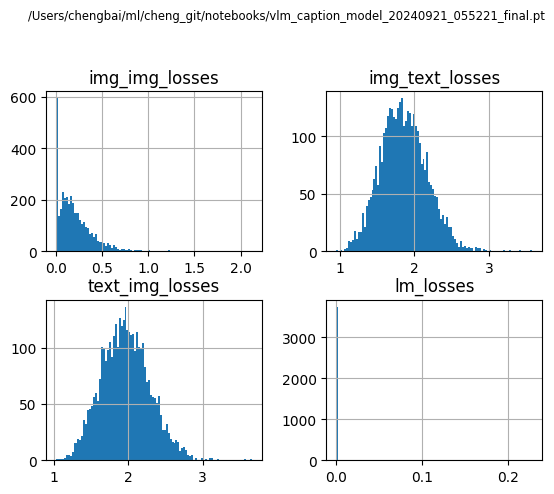

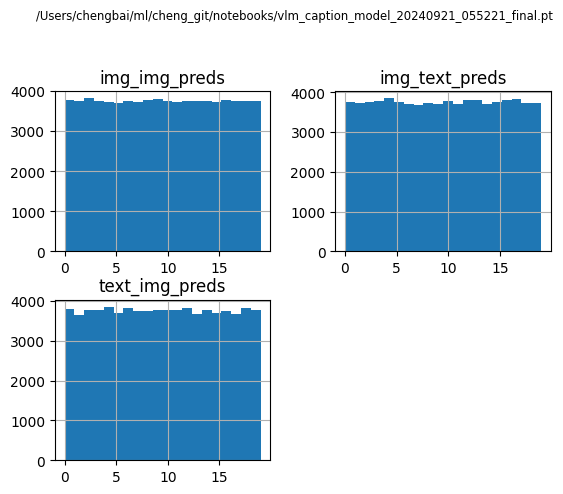

In [ ]:
(
    img_img_losses,
    img_text_losses,
    text_img_losses,
    lm_losses,
    img_img_preds,
    img_text_preds,
    text_img_preds,
    img_img_accuracies,
    img_text_accuracies,
    text_img_accuracies,
) = evaluate_model_perf(target_model=target_model, split="test")
logger.info(f"img_img_losses: mean-{img_img_losses.mean()}, std-{img_img_losses.std()}")
logger.info(
    f"img_text_losses: mean-{img_text_losses.mean()}, std-{img_text_losses.std()}"
)
logger.info(
    f"text_img_losses: mean-{text_img_losses.mean()}, std-{text_img_losses.std()}"
)
logger.info(f"lm_losses: mean-{lm_losses.mean()}, std-{lm_losses.std()}")
logger.info(f"img-img accuracy: {sum(img_img_accuracies)/len(img_img_accuracies)}")
logger.info(f"img-text accuracy: {sum(img_text_accuracies)/len(img_text_accuracies)}")
logger.info(f"text-img accuracy: {sum(text_img_accuracies)/len(text_img_accuracies)}")

viz_loss(model_file, img_img_losses, img_text_losses, text_img_losses, lm_losses)
viz_predictions(model_file, img_img_preds, img_text_preds, text_img_preds)

tokens: 10000
tokenizer.is_fast: True
tokens: 10000
tokenizer.is_fast: True
dict_keys(['epoch', 'total_steps', 'global_step', 'model_state_dict', 'optimizer_state_dict', 'config', 'train_settings'])
Enriched img id: /tmp/enriched_results.csv
split:  test
target_dataset:  15892
target_dataloader:  795


  0%|          | 0/795 [00:00<?, ?it/s]

tokens: 10000
tokenizer.is_fast: True


100%|██████████| 795/795 [08:28<00:00,  1.56it/s]


img_losses: mean-2.763059139251709, std-0.33717092871665955
text_losses: mean-2.6847128868103027, std-0.3467816710472107
lm_losses: mean-0.02429996244609356, std-0.14907468855381012
img accuracy: 0.12100427597761154
text accuracy: 0.11729171872138977


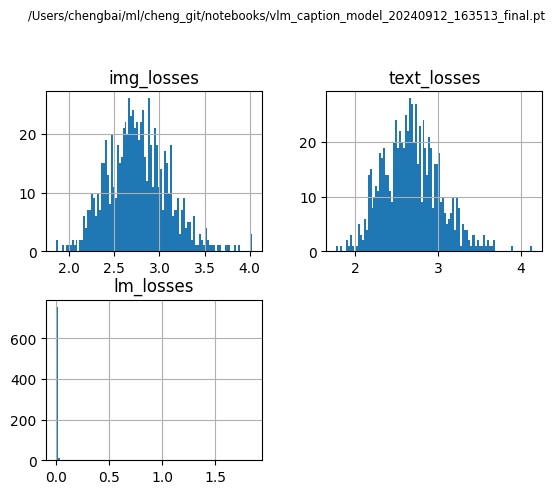

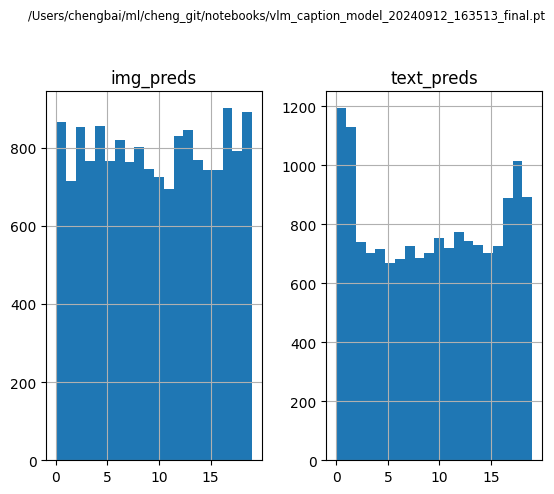

In [ ]:
(
    img_img_losses,
    img_text_losses,
    text_img_losses,
    lm_losses,
    img_img_preds,
    img_text_preds,
    text_img_preds,
    img_img_accuracies,
    img_text_accuracies,
    text_img_accuracies,
) = evaluate_model_perf(target_model=target_model, split="test")
logger.info(f"img_img_losses: mean-{img_img_losses.mean()}, std-{img_img_losses.std()}")
logger.info(
    f"img_text_losses: mean-{img_text_losses.mean()}, std-{img_text_losses.std()}"
)
logger.info(
    f"text_img_losses: mean-{text_img_losses.mean()}, std-{text_img_losses.std()}"
)
logger.info(f"lm_losses: mean-{lm_losses.mean()}, std-{lm_losses.std()}")
logger.info(f"img-img accuracy: {sum(img_img_accuracies)/len(img_img_accuracies)}")
logger.info(f"img-text accuracy: {sum(img_text_accuracies)/len(img_text_accuracies)}")
logger.info(f"text-img accuracy: {sum(text_img_accuracies)/len(text_img_accuracies)}")

viz_loss(model_file, img_img_losses, img_text_losses, text_img_losses, lm_losses)
viz_predictions(model_file, img_img_preds, img_text_preds, text_img_preds)

In [7]:
model_file = (
    "/Users/chengbai/ml/cheng_git/notebooks/vlm_caption_model_20240906_043641_final"
)
(
    img_losses,
    text_losses,
    lm_losses,
    img_preds,
    text_preds,
    img_accuracies,
    text_accuracies,
) = evaluate_model_perf(model_file=model_file, split="test")
logger.info(f"img_losses: mean-{img_losses.mean()}, std-{img_losses.std()}")
logger.info(f"text_losses: mean-{text_losses.mean()}, std-{text_losses.std()}")
logger.info(f"lm_losses: mean-{lm_losses.mean()}, std-{lm_losses.std()}")
logger.info(f"img accuracy: {sum(img_accuracies)/len(img_accuracies)}")
logger.info(f"text accuracy: {sum(text_accuracies)/len(text_accuracies)}")

viz_loss(model_file, img_losses, text_losses, lm_losses)
viz_predictions(model_file, img_preds, text_preds)

NameError: name 'evaluate_model_perf' is not defined

In [5]:
model_file = "/Users/chengbai/ml/cheng_git/notebooks/vlm_contrastive_model_5_20240903_060257_final"
(
    img_losses,
    text_losses,
    lm_losses,
    img_preds,
    text_preds,
    img_accuracies,
    text_accuracies,
) = evaluate_model_perf(model_file=model_file, split="test")
logger.info(f"img_losses: mean-{img_losses.mean()}, std-{img_losses.std()}")
logger.info(f"text_losses: mean-{text_losses.mean()}, std-{text_losses.std()}")
logger.info(f"lm_losses: mean-{lm_losses.mean()}, std-{lm_losses.std()}")
logger.info(f"img accuracy: {sum(img_accuracies)/len(img_accuracies)}")
logger.info(f"text accuracy: {sum(text_accuracies)/len(text_accuracies)}")

viz_loss(model_file, img_losses, text_losses, lm_losses)
viz_predictions(model_file, img_preds, text_preds)

NameError: name 'evaluate_model_perf' is not defined

tokens: 10000
tokenizer.is_fast: True
tokens: 10000
tokenizer.is_fast: True
Enriched img id: /tmp/enriched_results.csv
split:  test
target_dataset:  15892
target_dataloader:  795


  0%|          | 0/795 [00:00<?, ?it/s]

tokens: 10000
tokenizer.is_fast: True


100%|██████████| 795/795 [04:01<00:00,  3.29it/s]


img_losses: mean-2.9592390060424805, std-0.09932839125394821
text_losses: mean-2.9480690956115723, std-0.09810122847557068
lm_losses: mean-0.79759281873703, std-0.16128289699554443
img accuracy: 0.06984646618366241
text accuracy: 0.060281902551651


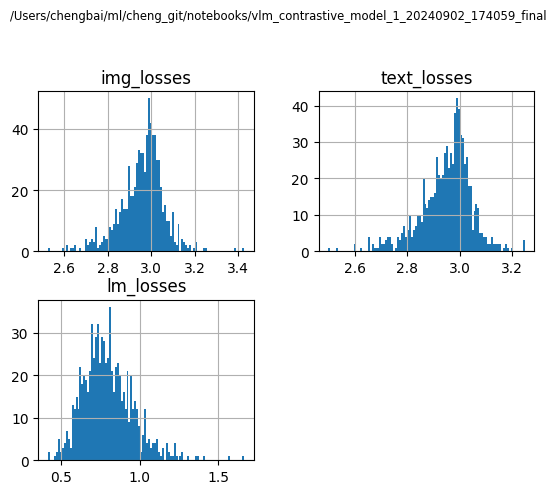

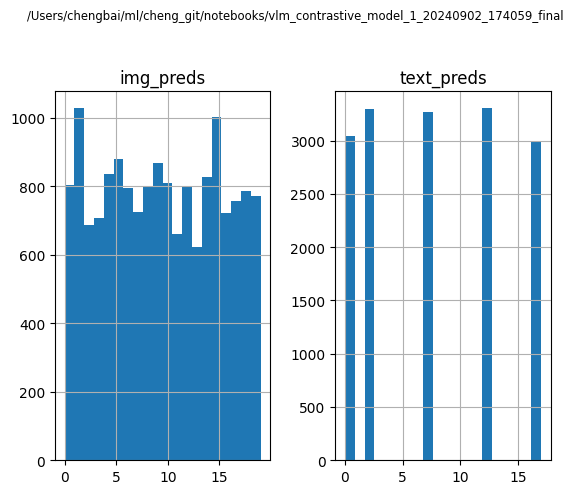

In [ ]:
model_file = "/Users/chengbai/ml/cheng_git/notebooks/vlm_contrastive_model_1_20240902_174059_final"
(
    img_losses,
    text_losses,
    lm_losses,
    img_preds,
    text_preds,
    img_accuracies,
    text_accuracies,
) = evaluate_model_perf(model_file=model_file, split="test")
logger.info(f"img_losses: mean-{img_losses.mean()}, std-{img_losses.std()}")
logger.info(f"text_losses: mean-{text_losses.mean()}, std-{text_losses.std()}")
logger.info(f"lm_losses: mean-{lm_losses.mean()}, std-{lm_losses.std()}")
logger.info(f"img accuracy: {sum(img_accuracies)/len(img_accuracies)}")
logger.info(f"text accuracy: {sum(text_accuracies)/len(text_accuracies)}")

viz_loss(model_file, img_losses, text_losses, lm_losses)
viz_predictions(model_file, img_preds, text_preds)

In [10]:
model_file = "/Users/chengbai/ml/cheng_git/notebooks/vlm_contrastive_model_5_20240901_234713_final"
(
    img_losses,
    text_losses,
    lm_losses,
    img_preds,
    text_preds,
    img_accuracies,
    text_accuracies,
) = evaluate_model_perf(model_file=model_file, split="test")
logger.info(f"img_losses: mean-{img_losses.mean()}, std-{img_losses.std()}")
logger.info(f"text_losses: mean-{text_losses.mean()}, std-{text_losses.std()}")
logger.info(f"lm_losses: mean-{lm_losses.mean()}, std-{lm_losses.std()}")
logger.info(f"img accuracy: {sum(img_accuracies)/len(img_accuracies)}")
logger.info(f"text accuracy: {sum(text_accuracies)/len(text_accuracies)}")

viz_loss(model_file, img_losses, text_losses, lm_losses)
viz_predictions(model_file, img_preds, text_preds)

tokens: 10000
tokenizer.is_fast: True
tokens: 10000
tokenizer.is_fast: True


RuntimeError: Error(s) in loading state_dict for ImgLanguageModel:
	Missing key(s) in state_dict: "img_norm.weight", "img_norm.bias", "text_norm.weight", "text_norm.bias". 
	size mismatch for img_proj.weight: copying a param with shape torch.Size([1024, 142688]) from checkpoint, the shape in current model is torch.Size([1024, 728]).
	size mismatch for text_proj.weight: copying a param with shape torch.Size([1024, 36400]) from checkpoint, the shape in current model is torch.Size([1024, 728]).

tokens: 10000
tokenizer.is_fast: True
tokens: 10000
tokenizer.is_fast: True
Enriched img id: /tmp/enriched_results.csv
tokens: 10000
tokenizer.is_fast: True
split:  test
target_dataset:  15892
target_dataloader:  795


100%|██████████| 795/795 [04:14<00:00,  3.13it/s]


img_losses: mean-10.27953052520752, std-2.624840021133423
text_losses: mean-2.229250431060791, std-0.5986806750297546
lm_losses: mean-0.0012080925516784191, std-0.004216477274894714
img accuracy: 0.050969041883945465
text accuracy: 0.051157813519239426


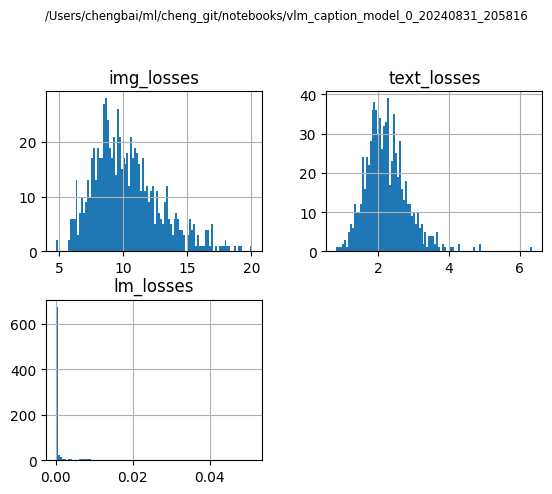

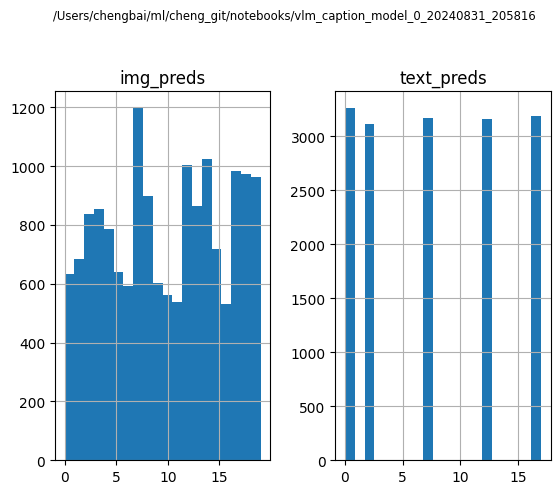

In [ ]:
model_file = (
    "/Users/chengbai/ml/cheng_git/notebooks/vlm_caption_model_0_20240831_205816"
)
(
    img_losses,
    text_losses,
    lm_losses,
    img_preds,
    text_preds,
    img_accuracies,
    text_accuracies,
) = evaluate_model_perf(model_file=model_file, split="test")
logger.info(f"img_losses: mean-{img_losses.mean()}, std-{img_losses.std()}")
logger.info(f"text_losses: mean-{text_losses.mean()}, std-{text_losses.std()}")
logger.info(f"lm_losses: mean-{lm_losses.mean()}, std-{lm_losses.std()}")
logger.info(f"img accuracy: {sum(img_accuracies)/len(img_accuracies)}")
logger.info(f"text accuracy: {sum(text_accuracies)/len(text_accuracies)}")

viz_loss(model_file, img_losses, text_losses, lm_losses)
viz_predictions(model_file, img_preds, text_preds)

tokens: 10000
tokenizer.is_fast: True
tokens: 10000
tokenizer.is_fast: True
Enriched img id: /tmp/enriched_results.csv
tokens: 10000
tokenizer.is_fast: True
split:  test
target_dataset:  15892
target_dataloader:  795


100%|██████████| 795/795 [04:09<00:00,  3.19it/s]


img_losses: mean-0.5474981665611267, std-0.2033354938030243
text_losses: mean-0.3965409994125366, std-0.09175096452236176
lm_losses: mean-0.0007577572832815349, std-0.004581856075674295
img accuracy: 0.05336018279194832
text accuracy: 0.050843190401792526


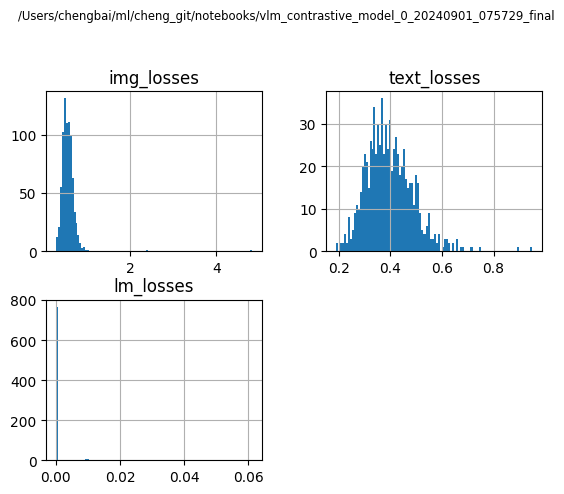

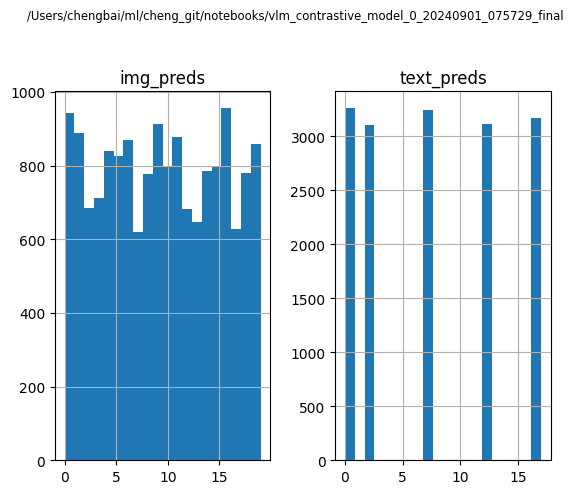

In [14]:
model_file = "/Users/chengbai/ml/cheng_git/notebooks/vlm_contrastive_model_0_20240901_075729_final"
(
    img_losses,
    text_losses,
    lm_losses,
    img_preds,
    text_preds,
    img_accuracies,
    text_accuracies,
) = evaluate_model_perf(model_file=model_file, split="test")
logger.info(f"img_losses: mean-{img_losses.mean()}, std-{img_losses.std()}")
logger.info(f"text_losses: mean-{text_losses.mean()}, std-{text_losses.std()}")
logger.info(f"lm_losses: mean-{lm_losses.mean()}, std-{lm_losses.std()}")
logger.info(f"img accuracy: {sum(img_accuracies)/len(img_accuracies)}")
logger.info(f"text accuracy: {sum(text_accuracies)/len(text_accuracies)}")

viz_loss(model_file, img_losses, text_losses, lm_losses)
viz_predictions(model_file, img_preds, text_preds)

# Viz Prediction
-----

In [33]:
(
    batch_aug_img_tensor1,
    batch_aug_img_tensor2,
    batch_img_id_tensor,
    batch_text_tensor,
    batch_text_mask_tensor,
    # ) = next(iter(train_dataloader))
) = next(iter(test_dataloader))
batch_aug_img_tensor1 = batch_aug_img_tensor1.to(device)
batch_aug_img_tensor2 = batch_aug_img_tensor2.to(device)
batch_img_id_tensor = batch_img_id_tensor.to(device)
batch_text_tensor = batch_text_tensor.to(device)
batch_text_mask_tensor = batch_text_mask_tensor.to(device)
(
    img_img_loss,
    img_text_loss,
    text_img_loss,
    img_img_contrastive_prob,
    img_text_contrastive_prob,
    text_img_contrastive_prob,
    lm_loss,
    lm_logit,
) = target_model(
    batch_aug_img_tensor1=batch_aug_img_tensor1,
    batch_aug_img_tensor2=batch_aug_img_tensor2,
    batch_text_tensor=batch_text_tensor,
    batch_text_mask_tensor=batch_text_mask_tensor,
    batch_img_id_tensor=batch_img_id_tensor,
)

logger.info(f"img_img_loss: {img_img_loss}")
logger.info(f"img_text_loss: {img_text_loss}")
logger.info(f"text_img_loss: {text_img_loss}")
logger.info(f"lm_loss: {lm_loss}")
VF.to_pil_image(inverse_img_aug(batch_aug_img_tensor1[9].cpu()))
print(f"batch_aug_img_tensor1: {batch_aug_img_tensor1.shape}")

2024-12-07 08:52:02,322 - __main__ - INFO - img_img_loss: 1.0728779216151452e-06
2024-12-07 08:52:02,322 - __main__ - INFO - img_text_loss: 2.292006015777588
2024-12-07 08:52:02,323 - __main__ - INFO - text_img_loss: 2.4815101623535156
2024-12-07 08:52:02,323 - __main__ - INFO - lm_loss: 3.530243702698499e-05
batch_aug_img_tensor1: torch.Size([20, 3, 224, 224])


In [4]:
original_images = [
    VF.to_pil_image(inverse_img_aug(img.detach()))
    for img in batch_aug_img_tensor1.cpu()
]
labels = [
    target_model.text_transformer.text_token_embedding.text_encoder.decode(
        target_tensor
    )
    .replace("<pad>", "")
    .replace("<bos>", "")[:40]
    for target_tensor in batch_text_tensor
]
count = len(original_images)
similarity = nn.Softmax(dim=-1)(img_text_contrastive_prob).cpu().detach()

plt.figure(figsize=(20, 20))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), labels, fontsize=12)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.3f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

label_idx = torch.arange(len(labels))
predict_idx = torch.argmax(similarity, dim=1)
accuracy = (label_idx == predict_idx).sum() / len(label_idx)
print(f"accuracy: {100*accuracy:.2f}%, predict_idx: {predict_idx}")

plt.title("Cosine similarity between text and image features", size=20)

NameError: name 'batch_text_tensor' is not defined

In [40]:
def show(imgs, comments, labels, pred_probs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    imgs_per_row = 1
    nrows = (len(imgs) + imgs_per_row - 1) // imgs_per_row
    fix, axs = plt.subplots(
        nrows=nrows,
        ncols=imgs_per_row,
        squeeze=False,
        figsize=(16, 5 * nrows),
    )
    for i, img in enumerate(imgs):
        img = img.detach()
        img = inverse_img_aug(img)
        img = VF.to_pil_image(img)
        row = i // imgs_per_row
        col = i % imgs_per_row
        axs[row, col].imshow(np.asarray(img))
        axs[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        title = f'pred: {comments[i].replace("<pad>", "").replace("<bos>", "")}\nlabel: {labels[i].replace("<pad>", "").replace("<bos>", "")}\nprob: {pred_probs[i]}'
        axs[row, col].set_title(title)

In [36]:
BATCH_SIZE = 100
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
logger.info(f"train_dataloader:  {len(train_dataloader)}")
logger.info(f"eval_data_loader:  {len(eval_dataloader)}")
logger.info(f"test_data_loader:  {len(test_dataloader)}")

2024-12-07 08:52:49,902 - __main__ - INFO - train_dataloader:  10939
2024-12-07 08:52:49,902 - __main__ - INFO - eval_data_loader:  2735
2024-12-07 08:52:49,903 - __main__ - INFO - test_data_loader:  1520


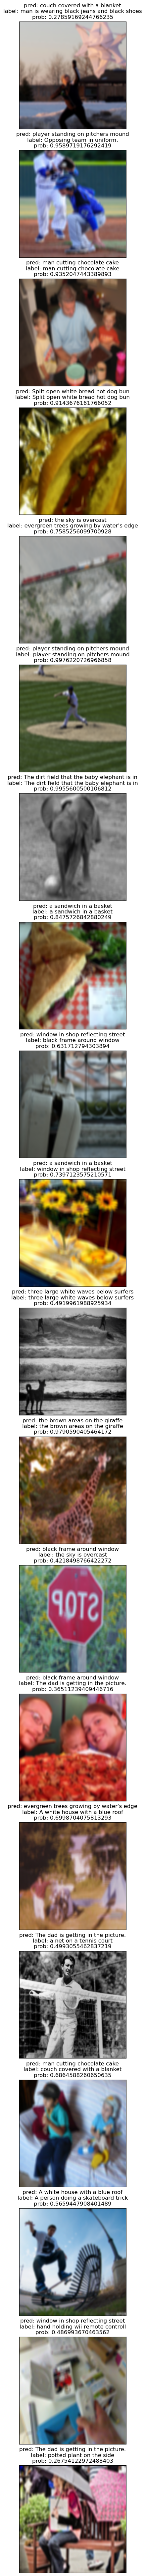

In [37]:
img_predicted_commments_index = torch.argmax(img_text_contrastive_prob, dim=1).cpu()
similarity = nn.Softmax(dim=-1)(img_text_contrastive_prob).cpu().detach()

show(
    imgs=[img for img in batch_aug_img_tensor1.cpu()],
    labels=[
        target_model.text_transformer.text_token_embedding.text_encoder.decode(
            target_tensor
        )
        for target_tensor in batch_text_tensor
    ],
    comments=[
        target_model.text_transformer.text_token_embedding.text_encoder.decode(
            batch_text_tensor[predicted_comment_index]
        )
        for predicted_comment_index in img_predicted_commments_index
    ],
    pred_probs=similarity[
        torch.arange(img_text_contrastive_prob.size()[0]), img_predicted_commments_index
    ],
)

In [25]:
img_file_path = "/Users/chengbai/ml/cheng_git/notebooks/highway.png"
# img_file_path = "/Users/chengbai/ml/dataset/coco/train2017/000000233075.jpg"
img_pil, caption = create_caption_from_img_file(
    img_langualge_model=target_model, img_file_path=img_file_path, device=device
)
logger.info(f"caption: {caption}")

2024-12-06 15:54:57,437 - fliker_comment_tokenizer - INFO - tokens: 10000
2024-12-06 15:54:57,438 - fliker_comment_tokenizer - INFO - tokenizer.is_fast: True
2024-12-06 15:54:58,610 - __main__ - INFO - caption: <bos>daytimedaytimedaytimes. s. s. s. s. sh.s. s. 


2024-12-06 15:55:14,004 - fliker_comment_tokenizer - INFO - tokens: 10000
2024-12-06 15:55:14,004 - fliker_comment_tokenizer - INFO - tokenizer.is_fast: True


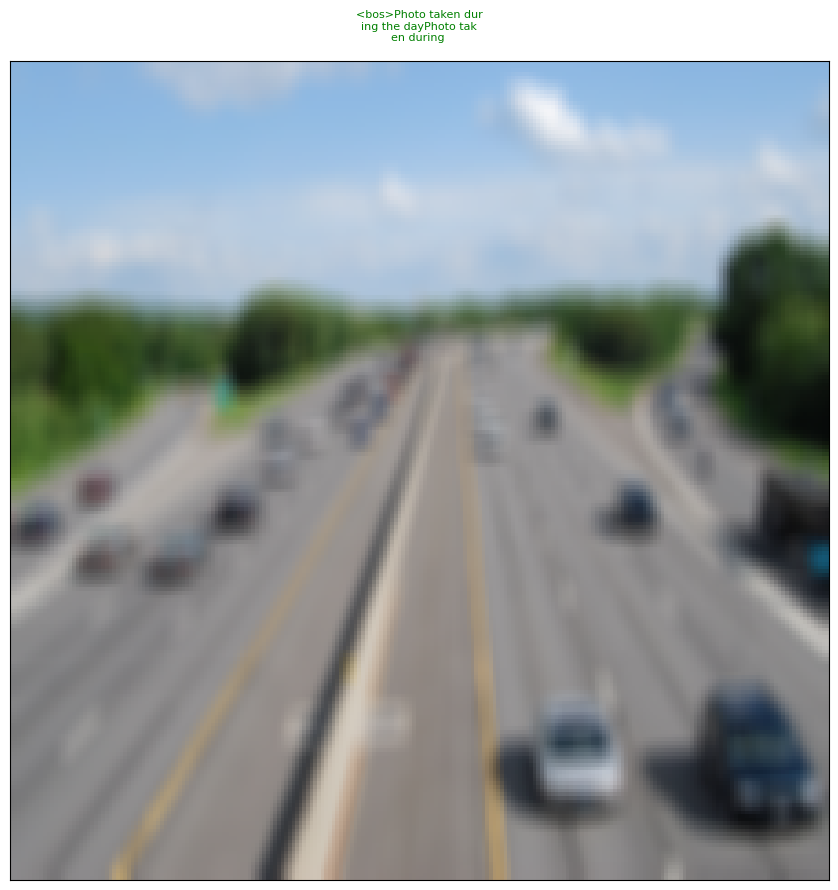

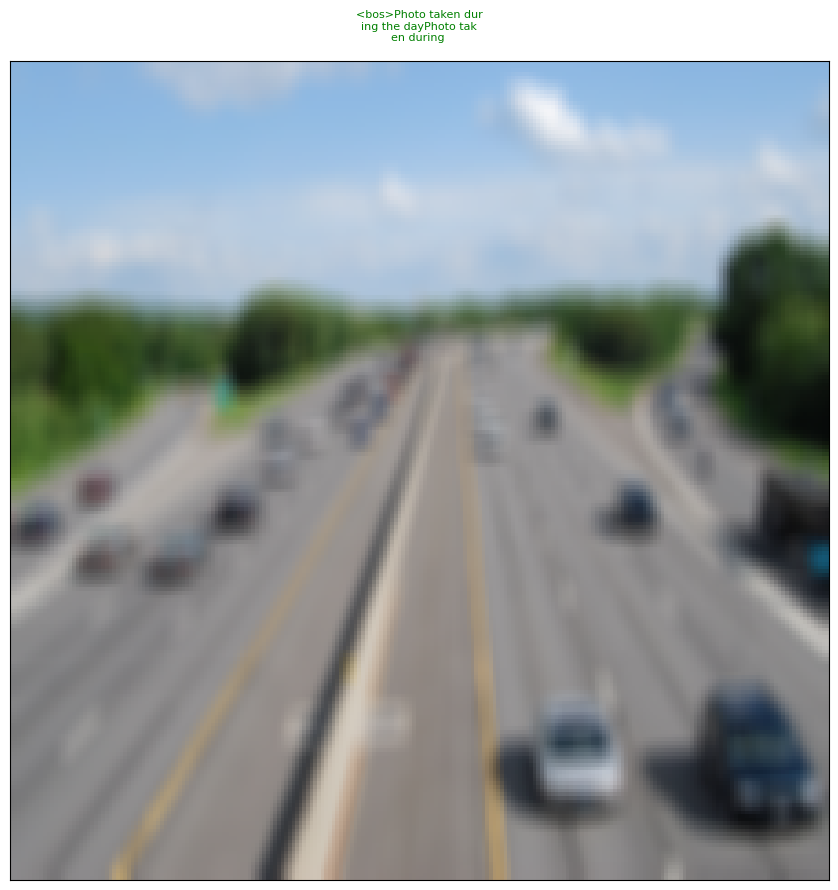

In [26]:
plot_caption_pred(
    img_langualge_model=target_model, img_file_paths=[img_file_path], device=device
)

In [27]:
device = torch.device("mps")
model_file = (
    # "/Users/chengbai/ml/cheng_git/notebooks/vlm_caption_model_20240921_055221_final.pt"
    # "/Users/chengbai/ml/cheng_git/notebooks/vlm_caption_model_0_20240922_140912_6600.pt"
    # "/Users/chengbai/ml/cheng_git/notebooks/vlm_caption_model_0_20240926_191754_100.pt"
    # "/Users/chengbai/ml/cheng_git/notebooks/vlm_caption_model_0_20240927_131307_10500.pt"
    "/Users/chengbai/ml/cheng_git/notebooks/vlm_caption_model_20241123_110346_final.pt"
)
target_model = load_model(config=config, model_file=model_file, device=device)
target_model.eval()

2024-12-06 15:55:29,961 - fliker_comment_tokenizer - INFO - tokens: 10000
2024-12-06 15:55:29,962 - fliker_comment_tokenizer - INFO - tokenizer.is_fast: True
2024-12-06 15:55:30,347 - fliker_comment_tokenizer - INFO - tokens: 10000
2024-12-06 15:55:30,348 - fliker_comment_tokenizer - INFO - tokenizer.is_fast: True
dict_keys(['epoch', 'total_steps', 'global_step', 'model_state_dict', 'optimizer_state_dict', 'config', 'train_settings'])


ImgLanguageModel(
  (img_embedding): ImageEmbedding(
    (conv): Conv2d(3, 512, kernel_size=(16, 16), stride=(16, 16), padding=valid)
    (pos_embedding): Embedding(196, 512)
  )
  (img_transfomer): ImgTransformer(
    (blocks): Sequential(
      (0): ImgTransformerBlock(
        (multihead_attention): ImgMultiheadSelfAttention(
          (wq): Linear(in_features=512, out_features=512, bias=True)
          (wk): Linear(in_features=512, out_features=512, bias=True)
          (wv): Linear(in_features=512, out_features=512, bias=True)
          (softmax): Softmax(dim=-1)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (mlp): Sequential(
          (0): Linear(in_

2024-12-06 15:55:32,827 - fliker_comment_tokenizer - INFO - tokens: 10000
2024-12-06 15:55:32,827 - fliker_comment_tokenizer - INFO - tokenizer.is_fast: True


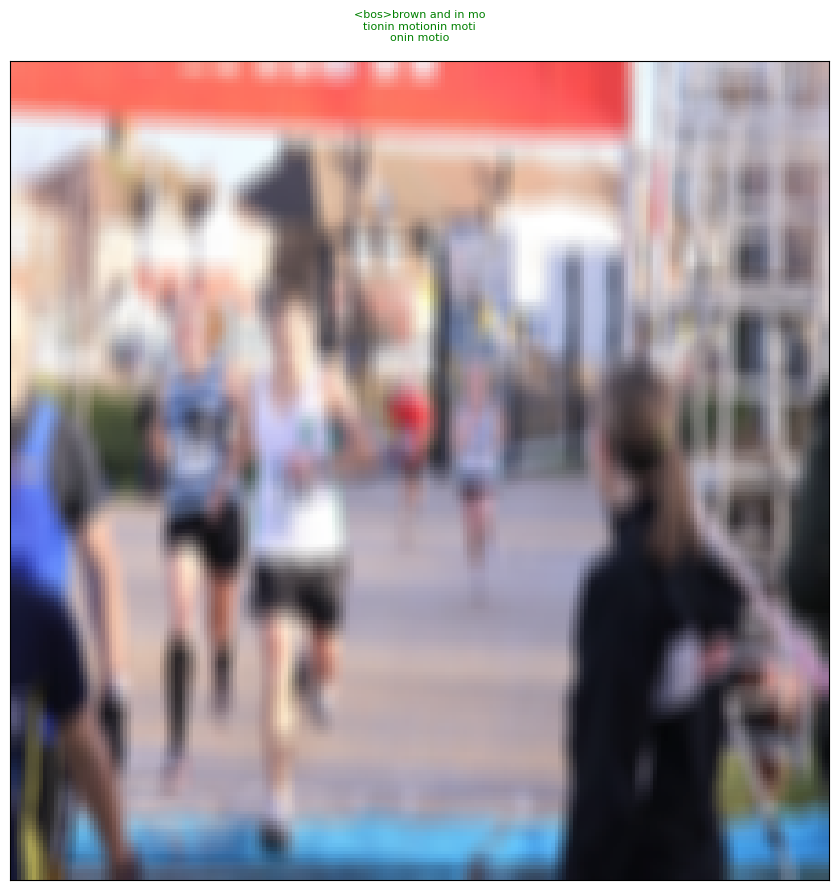

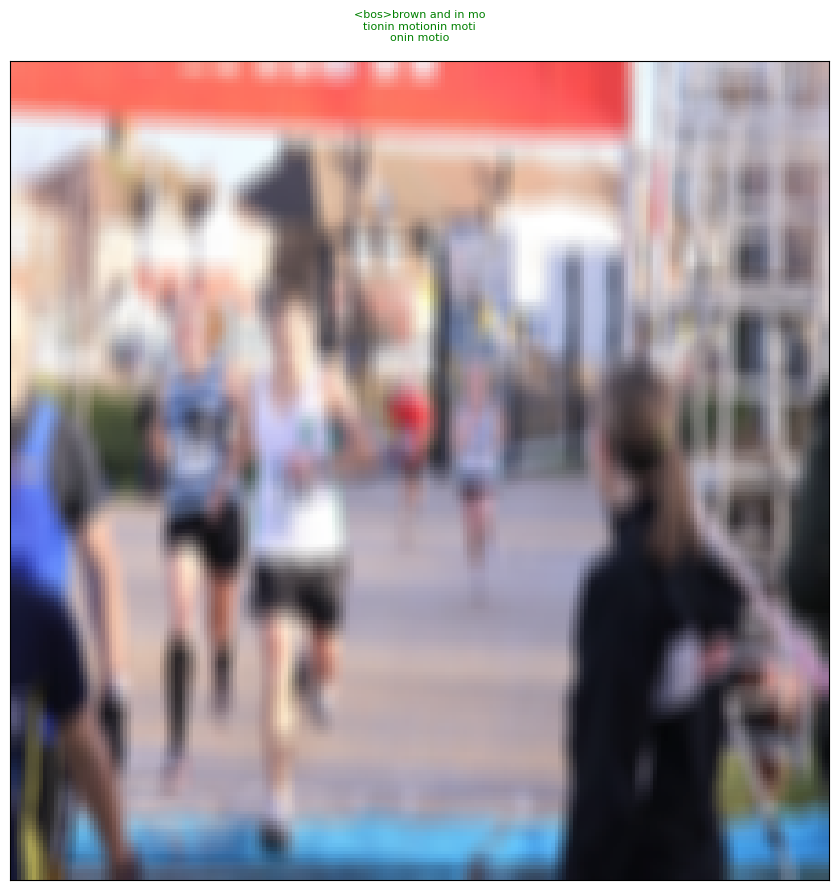

In [28]:
img_file_paths = [
    # "/Users/chengbai/ml/dataset/coco/train2017/000000233075.jpg",
    # "/Users/chengbai/ml/dataset/coco/train2017/000000233111.jpg",
    # "/Users/chengbai/ml/dataset/coco/train2017/000000348935.jpg",
    # "/Users/chengbai/ml/dataset/flickr30k_images/flickr30k_images/3273585735.jpg",
    # "/Users/chengbai/ml/dataset/flickr30k_images/flickr30k_images/428501119.jpg",
    "/Users/chengbai/ml/dataset/flickr30k_images/flickr30k_images/4282367460.jpg",
]

plot_caption_pred(
    img_langualge_model=target_model, img_file_paths=img_file_paths, device=device
)

2024-12-06 15:55:34,054 - fliker_comment_tokenizer - INFO - tokens: 10000
2024-12-06 15:55:34,054 - fliker_comment_tokenizer - INFO - tokenizer.is_fast: True


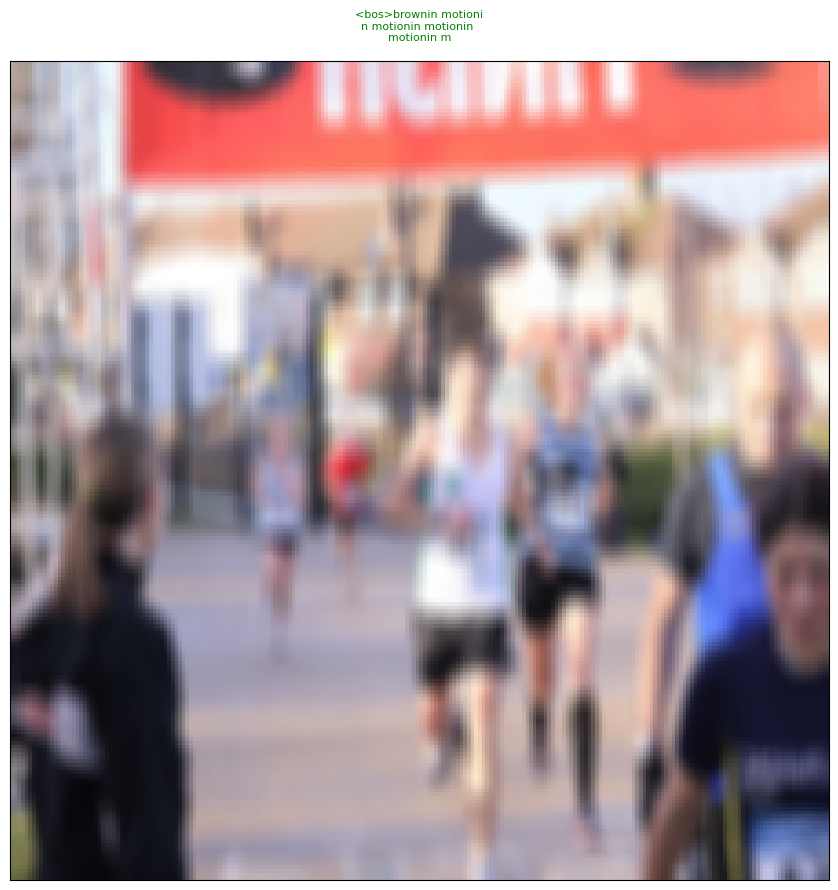

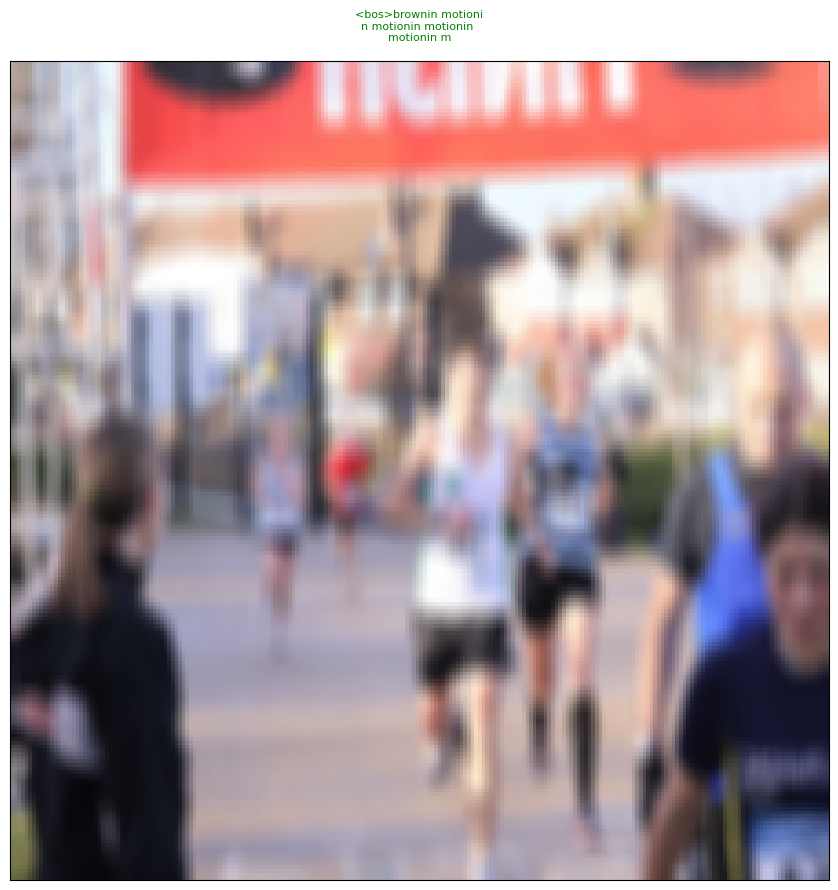

In [29]:
img_file_paths = [
    # "/Users/chengbai/ml/dataset/coco/train2017/000000233075.jpg",
    # "/Users/chengbai/ml/dataset/coco/train2017/000000233111.jpg",
    # "/Users/chengbai/ml/dataset/coco/train2017/000000348935.jpg",
    # "/Users/chengbai/ml/dataset/flickr30k_images/flickr30k_images/3273585735.jpg",
    # "/Users/chengbai/ml/dataset/flickr30k_images/flickr30k_images/428501119.jpg",
    "/Users/chengbai/ml/dataset/flickr30k_images/flickr30k_images/4282367460.jpg",
]

plot_caption_pred(
    img_langualge_model=target_model, img_file_paths=img_file_paths, device=device
)